In [1]:
import subprocess
import shlex
import re
import csv

import numpy as np

from io import StringIO
from matplotlib import pyplot as plt
from scipy.stats import spearmanr, combine_pvalues
from IPython.display import display, Markdown
from tqdm import tqdm

In [2]:
CC_PATTERN = re.compile(r"(?<!^)(?=[A-Z])")

# Spearman correlation between four adjacent individuals

In [3]:
def test_rng_correlation(
    mode, seeds=[42], limit=1000,
):
    total_correlations = np.zeros(shape=(4, 4))
    total_pvalues = []
    
    for seed in tqdm(seeds):
        # Collect random streams from non-dispersing individuals at (0,0)..(1,1)
        rngs_io = StringIO(subprocess.run(shlex.split(
            f"cargo run --release --quiet -- --seed {seed} --limit {limit} {CC_PATTERN.sub('-', mode).lower()}"
        ), check=True, capture_output=True, text=True).stdout)
        
        # Read in the random draws and transpose to 4xlimit
        rngs = []
        with rngs_io:
            reader = csv.reader(rngs_io)

            for row in reader:
                rngs.append(tuple(np.uint64(c) for c in row))
        rngs = np.array(rngs).T
        
        zzCzo = spearmanr(rngs[0], rngs[1])
        zzCoz = spearmanr(rngs[0], rngs[2])
        zzCoo = spearmanr(rngs[0], rngs[3])
        zoCoz = spearmanr(rngs[1], rngs[2])
        zoCoo = spearmanr(rngs[1], rngs[3])
        ozCoo = spearmanr(rngs[2], rngs[3])
        
        total_correlations[0,1] += zzCzo.correlation
        total_correlations[1,0] -= zzCzo.correlation
        
        total_correlations[0,2] += zzCoz.correlation
        total_correlations[2,0] -= zzCoz.correlation
        
        total_correlations[0,3] += zzCoo.correlation
        total_correlations[3,0] -= zzCoo.correlation
        
        total_correlations[1,2] += zoCoz.correlation
        total_correlations[2,1] -= zoCoz.correlation
        
        total_correlations[1,3] += zoCoo.correlation
        total_correlations[3,1] -= zoCoo.correlation
        
        total_correlations[2,3] += ozCoo.correlation
        total_correlations[3,2] -= ozCoo.correlation
        
        total_pvalues.append(zzCzo.pvalue)
        total_pvalues.append(zzCoz.pvalue)
        total_pvalues.append(zzCoo.pvalue)
        total_pvalues.append(zoCoz.pvalue)
        total_pvalues.append(zoCoo.pvalue)
        total_pvalues.append(ozCoo.pvalue)
    
    total_correlations /= limit
    
    corr_statistic, corr_pvalue = combine_pvalues(total_pvalues)
    
    if corr_pvalue <= 0.01 or corr_pvalue >= 0.99:
        display(Markdown(f"## {mode}: <span style='color:purple'><u>Definitely Correlated</u></span>"))
    elif corr_pvalue <= 0.05 or corr_pvalue >= 0.95:
        display(Markdown(f"## {mode}: <span style='color:red'><u>Strongly Correlated</u></span>"))
    elif corr_pvalue <= 0.1 or corr_pvalue >= 0.9:
        display(Markdown(f"## {mode}: <span style='color:orange'>*Weakly Correlated*</span>"))
    else:
        display(Markdown(f"## {mode}: <span style='color:green'>Uncorrelated</span>"))
        
    display(Markdown("#### Fisher’s combined Spearman correlation coefficients:"))
    display(Markdown(f"* p-value: {corr_pvalue}\n* statistic: {corr_statistic}"))
    
    plt.title("Distribution of p-values")
    plt.xlabel("p")
    plt.ylabel("pdf")
    plt.hist(total_pvalues, density=True)
    plt.show()
    
    display(Markdown("#### Correlation matrix:"))
    
    plt.figure(figsize=(8, 8))
    mat = plt.matshow(total_correlations, fignum=1)
    mat.axes.set_title("Individual Spearman correlation coefficients")
    mat.axes.set_xticks([0, 1, 2, 3])
    mat.axes.set_yticks([0, 1, 2, 3])
    mat.axes.set_xticklabels(['(0,0)', '(0,1)', '(1,0)', '(1,1)'])
    mat.axes.set_yticklabels(['(0,0)', '(0,1)', '(1,0)', '(1,1)'])
    plt.colorbar()
    plt.show()
    
    display(Markdown(f"#### Parameters:\n* seeds: {seeds}"))

100%|██████████| 1000/1000 [03:55<00:00,  4.24it/s]


## NoDispersal: <span style='color:green'>Uncorrelated</span>

#### Fisher’s combined Spearman correlation coefficients:

* p-value: 0.8090797589467585
* statistic: 11864.368559630866

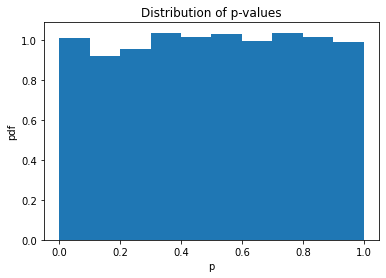

#### Correlation matrix:

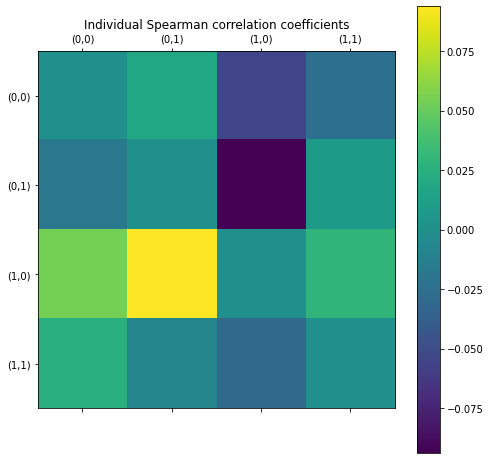

#### Parameters:
* seeds: [ 4447441386278451584 15207016417937318058 15040576520645061163
 17035486896072602887  5777643983486000965 13684210227647884962
 11887235321627577415 14304954100732735245 14974325845753260412
 16672028621224249004  9648888639787702264 11524213295705990265
 16262515018216336845 16033611188214021932 15223582455822902833
  4303744229036958402 16064712192272235861 16988361485668493792
 16720587061044169771  3943501949835390457 15882233798918488195
 17127194696703611249  2318730082506505004 14201300108954385042
  4584310966695434829  1268709015395155926  5137515666982857652
 18141847740499707789  6331981640482502257  7342003948184862835
  2042968846972385555 15462593149575046065  3673132254835871408
 17603516013404910239  5600731407781757201  3468635128434162920
 17486310543915912933  1222461580506743144  3987416452255368857
 12667364208820343969  5472040999092266223  2007695806388916054
  1457622310035268933 13874648921112154335  1662712471192079474
 18414816975178364069   890142757430543679 16796738827501972098
 16762876074717831074 10418373871637379266 11376888241480494829
  9400898003673348538 17834533692962089588 14445705788781000619
   250940854704573432  4199269225320997877 14518316557452065566
  3557125355021305666 17067147365669656829 18443203637029152589
 14886433033286438977  3635057894948035816  6841669308325210985
  8983558848994349859  3656647444352684247 11653016699508742246
 14174195420782593956 17097225100494266851  7394766668872749685
  6627616731320534796  6015815417331353971  9133382120894149139
  6960069171977689195 13843105524125309266 18433700329926802163
  8830935685093085125 16585509111835507938  5988957403616165293
  4822741492020974661 13913722153697682812 10749666191570339352
  4535214303393305766 15916626274183990247   392762801457231659
 14558643927316243038  4781127226533500771  9409754605108677726
  7949143142516708213  9808102925024120245   398763562034313239
  2929625356172341449  1621831636050076792 15268055261765129498
  8054180657415844080   297853682452629220  8477339380634163649
 16455728689773525418  2297076123015048987  9362801303857990356
 11294037776537486891  1668216866469732593   197510892338253462
 12622035722502840748 15399486920763670344  4098630168719210770
  9961540178673821960 13823617685707559950  4150524254092999940
  8926027384105430307   699774869196274901 14006060370109130447
  4565706518938669072  7040334352554027219   347158254383193712
   116057243182087401 14589463169008662823  3554656798354050985
  9620822896898202930 16610877090014716051 12351745976157542192
  9245018365608767617  2481514288415255861  1068793336001234319
  9503249372753758499  9211759776446119073  2758984271193896891
 10801675053475910708  5578495544784123915  9383808563694093110
  7726401625391853436  5680370015195047146 14719409102724330642
  1413246367057855021 14164430005361288483  1914555106252359791
 14544341163621652551 12038187907361626966  9959001203188202913
  4082079945878177539  6880225649281079239  7563851920466973121
 17856278741200606932  6844697892170909420 13938146157277025691
  9757599547278847144  8197831494530816126  6847230374255855317
 14931654238782791074  9393571514228889927  8353822477091464215
 13508433426642931124  9549866929598760622  7812703436851296048
  5569963277357626380   736803098316627216 15383117107298729483
   183995586097238390 16681893758344117838  8239386685900116010
 10689163200958678421  2091373126809007454  1413604550007005566
 15873202125766115714 11582526807772509436 16701181974627908199
  2941742201711905803  8380850524570881485  8216865037949244342
 12636603957039697390  7281087255354183323  7477497867461828717
  3919916807551717422   726150505976186481  1007656674594176567
 14053232882299163823  1000277910859865236 10662608843299177017
  7366017507127934916  5639968260600870317   264881293448453746
    56818017142808112 13412423551262556696  8428511065652553886
 14778624859975754121 16083866368942206197  1184801136831896470
  8005444938772025729 14120700261726847308  8371424406338319003
 18006663070004036632  2185854761495097291  8041499939237752958
 17236532657947680504 13257276845336594757  7881136244137232707
  7572577542685792266  3506341834862364184  6094227995390931050
 15327998749957876667 13312821743673461269   294594941396018684
 14006895608255443447  8026146166419530837   768147948172269483
  1578785248464111113 12801534745621896415 15651037533195079058
  4932932265517830700 11026113549830419965  4583086805701908776
 15080360369844001190  7778245177934874822  5107837365394993882
  1988919364727491299  4507488397775858080 14472667887985051546
   630510338995320125  7142775456235748653  4464866079838577638
  9797739142496538371   516895369113010410 15438161811650985692
 12582486770880753310   772821938551908255  4195296296912408800
 13312829290125927379  9378313233319236077 15488064036428360557
 18412784873689393041   745387730975815954  9727041221081233485
  6710356074048680661 13346839647109398490  7684796375498279164
 18235728427856989558 12933088709898184127  1893073004669698206
  1284357590640032275 10797555362631615171  3462682372216661352
  7202639274552109779 10486915227511425783 11896319141291742654
  6624769604352560912 10085549433017192194 11221623942754225148
 11899405960971137613 15332662426918572321 13371639038115763670
  3205901083095860107  1201700672309657649 14953047559429911581
  2728299725590230064  9147039074836216143 11056984195807658133
  1092357841408237958 12559039753380771701  5169106374314004720
    64288232394517662 10830168167247001279  3139670828968114531
  8178922149739928745 15900213133603323608  7729412650090484130
  2350562530787797024 17273921716483761415  1907551763354361762
  2561447435939786896  7092990862321141908  4588836617521972349
 10628654240005988934 14608632019252753255  8153975196627313473
  5084164597406826373  1665398614792273344 17480534713739707328
 16573324663430501140 15227774552602578184 10077628638853043845
  5385417232105869397 13306921667402250610  7654778676105304601
 15612782317391372833 15025179065641183232  9072030640081235588
 18339900663877697828 17823483760005065851 12839832722437616536
 10725865547178140429   145599684072254598 13089456610107682529
 12605386850713740497  4330140555165577070  6773527449623492560
 13315811861368239503 10349309337197463891 13704029728466933304
 15316684913985484669  3815444113140275632  7888246625901236244
  8183122567867308355 14876509214001111471 11404352552403886406
 13054896346388843837  6290845746472205366  3133437650749578157
 14345495331923874207 14901229861473985744  7286506641192922578
  1031208227021973253 11381440226991446930 12109715267512351808
  9015757049775353188  7465483061535232431 15128153770377438065
 14890135774582231013  6310264229538513260  7466354906748928713
  7032386429090560640 13195059269422242505 10735691050072326813
 14397638531958343124 14767720163686621692 10959452196468130431
  1890777071783899861  8456924353838091233  6109828900814310043
  5795405649030224589  8046200695718962649   974778967917786202
  9454523005104916970 12053388820328231128 14040052935724963225
  9074162141105832568  2853551168380072452  9461732986563839603
  2181645791586209663 12152684774430760835  8195642006956410876
  5742012694144005871  8609638661056452048  8584304556353148804
 11691151071266703720  2922676002415617183 17821996998614612265
 14558357821254435060 14778224883169960914 17874915907197225088
 14656104275194019274 15537490840343426974  2733797295590035284
  9933303852955590354  2200283223715134358 10377483382906844984
  3170063755094920771  6704610539697224383 13987678510622112274
 15067422166008968901  3855869994726394948  3212233288838156221
 18242617022513646693  1538966421166485105  5680073416430128767
   162559931488941834  1064834521134953644  2145288086617881058
  8243905021722574485 13937271712954078945 11187599771483156168
  9932291065224929336 10040999067137732546  2498859371740065687
  8625003656488216684 11596527501206709857 15421975117156295862
 13368218889356833954 16498709030589912312  5763560034458378027
  4972192348520931322  9620709252272592880  8795766638852109036
  7069548234928858722   802301822097406854 11779062005294424127
 12187418229120127267 13410606172918182780  1757077941845153653
 17745268248199501021 16261196029530709307   441566538325034594
 10255897548714777871  5871132999239828416 15489387849504244621
  6387516981746648559 13916668447790766156 10132227863500787252
  6517378088036748229  1781801966221714298 10055828517082356965
 15050499948940920559  3242761274359048608  6001586748463833830
 16676956144422665427  4232140371760516421 11538024492434312773
  6707281430382303977 18266055507607122513  2825218057031910962
 13744196660301532230 15972923642506827597  6819152121632138487
  9382960425636798711  3158864470292436380 17783507038229747277
 15997357982580466256  9821538156081304008 17300476652684698438
 14254347689311016798  4997969272941415114 10189672187750602213
  3970903006813337459 15435478282002735346  4514436453967519249
  8189172647059907180  9802909282269962551  1327656461379763602
  9798395785816778242   998086006563409807 14581380486475171442
 14962923439133239925  4588274774238583139 10218330058151837044
  5487035318120513620  4564994488171667832 17301734073734618756
  8704698996786303715 11857733820608856601 16263982580293530047
 18264849825002362699  5473118852291384702 11579395212306293693
 15191446968397588672 13068462610536027515  3653242960901129741
  4006646221444503732 14892145684025691732   933446186712398980
 14048271110805538709  6067848948923661166 12358803250702780746
 18383554509831721260   238229541570304270 16343768313955671454
 14749563504607185806 13246851265563311097  9028135200634534293
  2192246639989095302   824749821910821400 12833583237033153895
 11928545632569974880 18019607739297470262  6156759847991631418
  5307998597442978927  7918538483898371438 14592421586564317982
 12532973432477504460  6392603019584658834 10027592795703553821
 17937766710974188378 13198566414696780335  2328147321756328774
  6330625015313245835  8027898359779320823  3560882073166592784
 18095965742144293095  5474673585502577900  9023968788434465440
 17232133034955807308 12762971712952532724 14893278064970663624
    99460252307469723 15623266932808446407  1355857565027122485
 13582574138762843901 16446285475765223570  8233309117173758017
  9599498224967543652 13911856567877388375 10736820496135761358
 10944042850226955956  9517021789513788709  7038135995546681994
  1360488576764149479 11609792969202443488 15343175022537916676
 11771886130970946119 12263405130413908355  9725963434577106326
 16425804750277337598 10941027476477280790  3120532535603862625
  7881939825934251103 15395286240265614859  8264010897659094307
 16567001647899995108 13848781297376300009  7352304595050366615
  7451936445417967614  1617248578575912731 17782456604875834460
  7547560436989772299  8535945522623904098  5545677496249390812
  9518458390391693579  8760993940828616892 13138921949169609085
  2786465186275617875 17372885596481332839  9007498986051898258
  9347874206142295846 12724351809969914599  9200281513330911619
 14188463703718505656  8218666591459747546 14243310488915384803
 15394279795117654478 16956975202690933894 12294681860949297463
  7198546074287728175  5647861814574961770 13479170556549387602
 14848606079387851659  1226254539764084698 11459444904846583110
 15088881089465330354 14477147312228156697  4569691951226742268
  4817376361824250219  4443853698331642792 15711760609547051375
 10017463173617236931 11875273735076478662  6176372148367383346
  1167919850418149887  1249439159726853854 14047631974935278477
  2695500065339687759   842574747321658085 13444208635530967851
 13291796694477143806 18187202161639881730 12590903991061794238
 14026997706473501971  6703038734619027690  9252592693066797892
 13077283685721664279 12172009244314369542  4738555070892563604
 10653593817512619316  9342620837653090848   889054368394518035
  7137870305189904370  1703927052681117126 13380593130241944524
  1596792730566988498 12996728696241294794 16703345273364235821
  7365703505827181018  7238425635160988700 14208064664108852514
  4771553646058823241 17513740008253654101  1963891556999963238
 15181863409216206308  3746361762217112933 12916711451993676582
 14787360410021439841  4276445946971822526 11670317214790114351
 18412859234985130836  5900405752155007822  8025591861479803041
  5083880975186261636  3158134735666011530  7170431278564892130
  9523524932763950362 18034714337002593112  7293506166622015970
   366678846310829728 10430192916191618316 12561750387930580211
  1982358634420313438  8366872671442057292 15370244655282104834
 11928836505368211129  1289177087316533862  1945837695838823748
 18045935973502192491  5165231352707104004 13693479496739688754
 14745969922163301449 16748353710241327665 10994633059181125903
 12936059429481132596 15830255892010921233 12296976782683788904
 11768873318825458048 16218885358535030013 18419079997350926419
  7649212340572675947 10671572742473478168  9560384847693741726
 13291338739800469653  3936762516318993496 15286092645603300801
 16153476414290895657 12689247818159922952 11931247600577184895
  6625414686112794364  3435104485158933418  9005584787487397031
  9262682079367450287 14459129950373455839  3745842011412067944
 10559836482653027351  6178436691235550531   217557629068744922
 10369730565936562679 13987711599991365394 15136041574211424968
  6886497670953073945 15488231800431308667 15792652464377944937
  3570613796276837484 12929981623778655769  2198067078934791458
 12876384492398714771  7875090676770054048  3866620633503250386
  1326553600674428581 14227230952304652944 12363666901362477410
 14605345605413701288 14994005356151249321  9977598778029929840
 16940092643020810290 15781720133088733980 15045113310884207213
  2420514007591987461 13067877109189552482 16997581507035549421
  5498438816642624251  6989198080379816216 17308996961596158411
  6573954152233707245  2200711736339211198  6374156603748434249
 18169913474291680071 15368777126391149487  8039245792996187203
 18371838953078824869 14922543927918262312  3349818197176762543
 10067053830924833982  6021607976977899287 14070861508580332988
 13384453456989643288 13422437434911406174  3052490068922081853
 12198499330085602927 15705475945879276329 14223126064680238790
 14156514675563847079 17406080989001607659  7085003599905063204
 14816141370911898679  8821615810363729836 16631635368559202627
 12143355323823610309  8765981420668983214 16642688580378271896
   925944145339170686  1789245609328269710  6988644816163188050
  2156963269036149597 13940920086256258345  3098981541028058679
 12020909002985900005  8593881950351623609 10832354221675025939
  2068191447504101620  8351021459164936901  6283339489743295617
  3141414142504004965   246020917054499224  4002954042690351710
 15840529358029275470  6559644679942307393  1567983222477458285
   594182621994029558 11510820921115844551 14420872086519398992
 16985120613360956669 15494064306220734502  3695333504674187736
  4971515406581889102 17443499670731457599 12954418485088918976
  7413192624345028941 12279654352759402672 12214181418782518585
 17997084440811707532 17773342898427767157   635418698926197995
  1322315383166056588 13445727415661982055  7248581748465935635
 10697116366074614844  8759433258277688449 14595705232890095820
 15729505315425900903 13195680274098352724 14239647578232768175
  5135311301839060567  5176707419707303971 11024244778577216599
  7900161847622533850 16613265427467357429 17151959553555260287
  3019991653047075117  2091010317709260475  8077925816514410647
  5217672887821742096 11058635488980846086 16819755983490181219
 17602375236358984811 10047855111796784193  7664596617037787210
   947887020351738077 11306680156822212593 10412064934905185242
  1258747092619626112 11584112359959008719 10701690135906862155
 11401327871871427480 11142366629825234875 16626473982350419897
 14875392633553267216  3558636952745557251   591586256285954394
 12464436386061676405  4912793503926240221    80204857296844654
 12809272672796002709 16334515455993473880  7787401341448581561
 16680986124929500443  1224038355432766869   210154345799086622
  4796897063978396681 13885362896276767278  5702288384111323752
 16024476988620367241 10666108899934681326 14437966775541838679
  3610900856836359591 11261151149665361608  9206270682958778206
 14847172359307060987  4362859129739622345  5949362890566189553
  4243108155589660602  1443657141641418227  5723631699634475269
 15385107034123213476  9753524138785327856 17486598877806776619
 10915055650331968917 12418004532553695297 13834572488461039888
 11595059914566217046  3979056133049829175  3814654163850732365
 17551580896607972933  4793219949398831175  7124609414926175897
 13219884772741216735  1725065599854496516  4252190846308438353
 14469464695845454734 16346420474828261044  3073534685142892011
  3014632475511141281 17858732632259987761 13401596943809982864
 14064840303111161078   560683030999629903  2909444089605034477
  4365909414212541768  2901706402028879764 12890945729742307634
  1886602941452095789 10300215288361845345 11982525700457127141
  8293607547230449796  7868682528955860796 15419298494608087796
 12471053157081923179 13512928119025158689  9249594801044927763
  4448089470895918685  7657712403771091048 18107329488834942948
   842099923624015906 17013763786617571619 12293306246550663134
 13016031570868703241  8310267032114673496 15163517053156611227
  6655347695741573589 11713466039938641426  4981606930350926356
  2382518924760835803  3510113484927797066  6592754180019014045
 14754298425819814374  5032139192604552084 11816817950509376987
  6135988857704740065  6519893858554667488  9612869275416263511
 15397501432140844169 16521031068545804190  2475736838258289110
  3402275757099148458  1523470955758318085  3872591870968578547
 17594141422666804897 11666230765687701808 14187985603887604175
 13349959963827099545  8393351319265423825 17244498903891235421
 10254559325476572714 10510010462500809237  2420780530150299361
 17144547092906400738  3162073116033163516 13457678955153105838
  1975973181152689077   722409651566208748  7229803996045531128
  5333025174515504720 11943837058372493454 15380791680718447112
 13223658942724998948   575924484124145099 12134231181438566884
  8125788367038412354 14844758458060022408  4992437886408341603
 16685881917655191957  3659993419854316381 17503516260122524165
  9337329278373587395 11839982896029044683 13143085610486927557
  3662588003752493201  3339682352714548463  9264608869474451081
  3173456839884112995  3453146355380536861  3780593286889523895
  8409374489465319054  8970866859956882849  5240015787557174350
  9524996151458891280  8086038838747754761  4680464607048548905
 17630982200097276978 16355874658448860314  4975055936980182509
 18278286161172484145  3048032513540345386 15394809741631744077
  3069007851031626822  5480227729571780873 12592443167983034065
  2188940960171610193  6583357634470868669 15528223803163925509
 15180903610068118645 11994386818755120057 13400553333341972450
 15854150165370789770 10562560847128363662  5915350861961341199
  6466204579080141073  2197861416779149731  5601333751156140648
  7878852724746382399  2636025318137857308  8042396123106486848
  9030516349537928559 16444099377914516925  7497114622640518204
  3779798958240736564  1433999362435371962 13841441159713720999
  2825616436808790058  4657187254543853262  9600919874439074931
  8581663707548684644  4008230090745092228 18372794779079393616
   447662159034323070 12449163735578169867  7687352332253471690
 14397913557334858167  2170300310034999738  7789310445615608778
  4317759033906126311  8382017438967622944  4851470487129161309
 12376813659157434710  5109507289464229501 11906750109751932241
  1870807573951335243 13161064721258004326 18176473928707830625
 10213261829950478541  2763898081247451645 15577189079373430482
  5271619608256238142 11654346877469613801  6623776944489286349
 16602288131653321928 12807777593698157540  9116079399705534167
  2351741944298667585  1267989626375140247  2122121807883377421
  1429661333867373979 14211947208349566558 12894838195631076526
 10082120544273534057 15610302014169565992  3814974189337774865
 12961264831833604088  8545191362103987931  3175601493575934311
 12464997237708923629 16541563967904735461  5413492387685850103
 15336078450561357355 12984528917886897079  3569529864561963206
  3276707718105863033 14257794987119930914 13702881907879101115
   233279823699808939  2185669796469848168  2603637119857770189
  2852080459979548139 11071489483630179570 10631509469603681101
  8688015686158637720  8655622656647638687 16944564522158245157
 11667611544906192229  1739650183728979983  6273499660802659819
 18134939006610816899  7316373711296081114  7155640441032194598
  1588194095809459359  7609598574902985083  1011191966328167869
  7708976154731442073  1037570522918502938 17649239007229458574
 14902308186314576368  5720767202248817903  6789250706130551255
 11697368763644854417  5437456800693511662 11251851880849452233
  2985563677437346412 14586616143678232963 13816105371202220103
 16432897169404032681  6346235064963906168 13476929024834526179
 17935099735379044696  6128930196136198800  5908903598597454203
  8297428488866301286  7175101918106226300  8806049883333724166
  8728587223248397269]

100%|██████████| 1000/1000 [03:32<00:00,  4.70it/s]


## HighDispersal: <span style='color:green'>Uncorrelated</span>

#### Fisher’s combined Spearman correlation coefficients:

* p-value: 0.7780610253748784
* statistic: 11881.111969332569

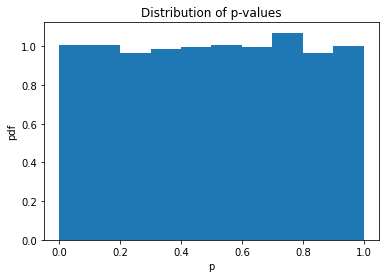

#### Correlation matrix:

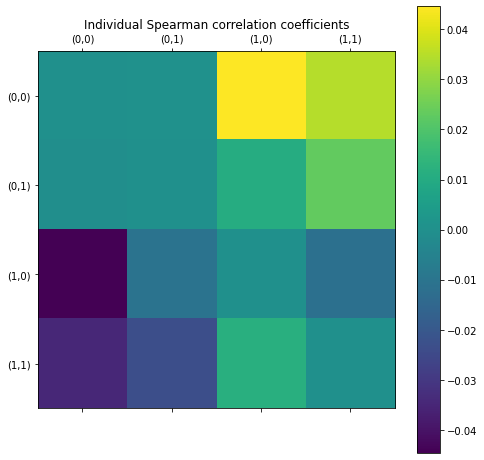

#### Parameters:
* seeds: [ 6140923656129797916  5910967842452250272 14718614129619514210
  9797674387046193087 15153361100005265470 10165483537017574895
  4306304013039295795  1169251949167939687 16295172072718899071
  5741740089177913802  2639712918986726738  7873185551320915090
   803074653786906520  4361481591632788372 10208205369731514173
 10606951335302314194   277790665312281421 13629465298151590459
 17900445912584776100  5876602572413143336 15255707474281133589
  8478511314607123756 10480658620570120684 16837252537399003338
   198029468877231792   185858679865159472 16655627452072389272
  8971236729931566102  6203709869868918405 11082141963655728548
 11985523952704297269 17122192490371869795  3532007588691855705
  7150572289725035601 16493377022113897845 10930019344627641923
 15978355709207055587 17484290116364921518 17140847156134423415
 16804287659383340999 13304260818332359896 17414374061617075729
  3660096906471117248  3310089102774302203  1546877970338040601
 15791474727128315762 10073010082901890633  5664133199992987654
  2130279534455314791   169247258118226656  5396895404126821325
 10372094017680102415  6576102237047398592 10319356894166733084
  9864411284792869792  7287907726003610279 13601780626220232319
  1109846174872966072  1456989224112200214 15137861193145841263
 15331501690766734711 16470240377541917398   508689714016574982
 11710214086268303965  9957686554942423854 15999507408398260132
  7800522987696877490  2830571899318392719  5098021124712038033
 13319489566763312445  6041351618742185255  3237802574225020744
  7824805370000114882  5929550435718377669  9691551567653628575
  5610429707468008575  7448248528895728007 17217321486885008862
 12947601313219691603  3788838514975285775  2024504257229417047
  5726040038662149239  8820734171783552677 11844907781213217460
 11985665044494700341 12746826655413025886 10050033347175699244
 11501767595969100591  5491460085580449924  1925705868813824946
  1526116964228397721  5691153716565349652  9576058291757075969
  8499264994309543285 15434032963904201279 15789739744549183177
 11222585179035443297  4813817848668452497   882763861756455781
 10425566243026789044  4536659352500406145 15638483532438314499
  9851006702451861241 18428117743965399929 10951386600340421470
  8320233733926212665 11386002460720488794  4304224505747946255
 11977954623678436848  9490519732979094419  8157888605763232867
  8796939244082085121  9738734355239344787  7505020948959392166
 16775914491860150623  2421227700879790133   422525803573231026
  2662914352010684307   503492943474041420  4482625668306971322
  1462199858291988170   869613354298552963  9475103210004531625
   391196329415073970  8283129683005844504  2725463264290129652
 14082955214657836349 17132694081157467600 16737145297187973297
 14150131018844678003  7795647263466449993  1323483657628223335
  2266264408001089894  9782700893037334306 11716635382199693911
 16346020869107613089  4568292483602417744  5405909856116586892
  1587539033799918570  8307611919472582936  8597559268581878736
 13557901700327092317  8490245424410197419  5456049269690709212
   148295232597485325  7361815473043828429 11380070115096548361
  8642115909017672670  2910596244686046708 18302433787082993027
 17739398170414507939  5020353167646216187 16477683126319258239
  7617587742554532511  1414771749510213278  8762071728492589254
  6745745002021998385 16137525384283937250 16174740160715255705
  6502213656304916059  4549761387976029374  1219941284806165715
  6159926948051054883 12608716123985285532 14007069401819057771
  4476766731925341050  8190315033587531233 16982320164701480023
  6199912050910260804 12875240914315887591  1716717712557042718
 10423271622013688920 10909912773571817829 15082155933780423147
 11444506354692450627  3046399257306596953  7309827097085001794
 14695265573633939434 12656994423100706640  2225883115919147724
 18124825885420198762 17142574611040719598 10055186744193174316
  7426009285178060929  9741751701523281726  1247522706705163845
 12653889884506757775  4120014147606315961 11661044979443133041
 18230597658414672709 11137694943297770891  9755100810702463953
 15099141512684422194 13789419080228192988  5834973314867668764
   114241102237144132 13461982975349817192  8349692697542115367
  6273858893691211861 11079326414398044774  1127537664611792334
 10906198144310171642  9872708820820464567 18282394253210587263
 16100562080508659003  8434392831826436793 10378727845469421295
 16063205030331586843  3335909243788593606  2388025782960689571
  1194784579885603578 11563776188506700496 10541040273962930645
  5892230763767123275  1553795463758992662  9286988044645269628
  8270809646151140474  2638184501669546442  4058032205677203432
 13897464864566804902  8043281418717967486  5454770031533660047
  1484399818948383429  4097415064157376220 17938083651932416571
 12167606808450253704   808517366938706661  4692247949846070759
  9181370251790098622 11481509135082097350 14378196072610993249
  7974638457870235581   113074754448807734  9206725506149049285
 13951997043206487847   250778746492684806 11375238625852566227
 18139880363926325814  1244206266428471063  4858827183691775178
  6334878841890672533 17197437488681588202  8171556331432601721
  5782664039168622111 16598277084002418295 16202516707718272181
  3806403701091937148  6593584361291607674   873059211208815153
  8187128195347210602 15326751377181578249 11226878562739626408
  2072300293743936724 15776837413539435143 11269219345566617000
  9181679152077924575 11507319337342219060  1899229590981079821
  9506149632801387819   577554685867020341 11629629407695859235
 15083072377528330391  7529029630482560461  1781425081705228344
  8084796059459865259  8400914553285066816  4976049787040006001
 16668958018747072539  3736000547504528284 10666776733168367621
  1795996847833856430  6403797085314313879 13874184287868345586
  1283331169937216875  1589083956663495471 11813376967528427609
   452868446051246398  3674449704330332693 16421776963031471599
  3789260482338481982 10270180422663236121   395109126183944091
  2737772294181327827  3403450965452995394  1920749088993349598
  4562563359330571691   847335630336088152 16726354498630314854
  4361059019595593308  7493532788552537128 13040879153956407995
 17596260026853167219  1879316774165587329 14694813079520587397
 16361125622797592483  6731762439277343769 11957245983927213467
  5313279688644281583 16774610216498981852 17233125811118968766
  8367314202672352890  2478342759919950220 13693582616807978166
 14024526651337651445  9497902222034673954 16960269117669368862
  8245332395829795408 11227482285069412854 14324435268154278847
 16666858468037859031  8114870281091972996  9133210806674350377
  7760093770823954121 17368932977001347910 16568984686402464133
 10773686419664240103  5077047871550610142  6750908984646041254
 13468473343264108007 17747795237864510973  6802858385548040625
  5395576541175292536 17007715336162761180  3410271034291176394
 16647054755524240582  6671562818837782545 11785471531409877624
  5298412873291807753 15410203303338225420   458894909798389650
  9962467372558491150  1451342125902011090  8415326608091277231
  5737123896092627499  6168636586338793432  1326584241650493977
 13348703861091034005  1037538713934761374 14029286442692082399
 10369173997623608067  8456073266700007550   694827275924854196
 11315105783501519644 12787112778160515835  4981719011340457374
 17407446827170438694  9305080927704048008  6844377334548798268
  7243003274736112839 12228499726879980095 15656735945882435596
 10665689156630958902 16857814288093137945  7550407417139593543
 14578890956814535836  4969101433564555376 17821382221868606019
  2486372113068786536 10996527098652551140  7574749471518365787
 15729515379167856576  8794928627223354664 17279323097651324173
 15266479339532661137 10563188075503307312 16883684384073821832
  7589139590952673871  5896985043931642593  2841923657567676065
  2724082253270138976   525543113341307564  8675450355379711585
  8804569492853530912 18130675374176765319  8851506515565597668
  7070560204779197042 15827314714933336229  1709146696620518086
 15138301408531801549 10607251409824295058  2588932023199160652
 12420181483913088829  3999810573613449691  3005873496890866497
  7744247467557858817  1045631402221161418 14377961377273141189
  1672204450303156753 17979614346091242351  5860804998209175028
 17644247292170233502  3367367410381500708 17333719895718869698
  6564435181678429109   344114541942529661  6589954516352811384
 11719877173802769036  2764893525888441156  3551393363923639834
  1591536678325817016  6017085626222911031 15382018088953625431
 16422387120488473102 18300577814774000385 11045530454053569314
  3449422746814053695  1199250523236884258 11715592847443345264
  2195782595257009589  9603121634580519014  5753854005654149436
  2370268128517020808 11571803961117001533   949286429419737838
 16731606719355238753  7652659878397430553 13443514058183182952
 15819053296951840771  4609554443196012638 18129475386727720210
  7005125449810329510 17993914540037231101  6564545304288646013
 18054787685293904808 14055254281772198053 17815165364290316591
 15642525659678475802  3999654118376152252 10257031157066763834
 17516872892188048863 15272717108099950183  5387618732684487781
 12326508623775528641  5350326296150448598   262795040916150342
  5709461115664569320    74461604905833871 14051889797407821815
 14744290968509441186  7087309143865988116  6353908089162097131
  5799939756030559612  1004309523344192720  1748294538186282334
 10351413402266617932 16826853325406891494  7089684572521064686
  3963696511583164720 16085072386992951808 15647459630419377295
  6450593766603742972  8332873681246931529  5473487434200583753
  6824882908503572178  9780524690035907444  7322956747254417718
 15971784654572861097 17240586221341270057 17490358003409001222
 15485560349495962059  7091174356066233024  5654522002740912877
 12152317421729734300 10578957204820455807  6196716555443449694
  9938271094624196125  3096711004670893247 11530392664113389023
  9242379037594608720 13809512233546321254  5208425702461592141
 18130858424055521982 12187135113542253784  6041909480346084449
  4391224506927727539   531507941255970811 13282706831180285550
  2817288914010317016 10837636149505209222 11555169034510493339
  5826218225535274695 18291981848387791347 15747005495169081549
  2250601884027190381 11028215172007604323  7482134417735916125
  6537267550224502686  1980508702210648290 13814608362091552771
  1003538568632313340 12057827539020054673  7592876067370744787
 11896216264836926940  5033456725148328070  8317131367961973018
 11069097751805624027 12868000771568671389 10015766342709872683
 10292544324677411182 18012958448702464258  9634669686755243742
 11438073840808246855  8687957298510232309  3234924431855253964
 10171246339308697287 13122136855741603934 18022054192869354258
 11063453154886341090  6055417498531222620 12852032183629507595
  7292497816104917820 14320686906762074448  8270260226917475688
  5088734118769770426  7705890868633247799  7118257204456019246
  2968613154288043243  3583725276536725802  7696625087982462105
 17368671366209824672  1412830343531139509 14350347954367018786
 16755163952121120464  1433135844323655061 16762805995552878012
  3756947738474524467  3206443650045665411  1189083716008687362
 14068858487126527985  1605037540192590427 12581331177152675562
  5886134753726024394 12085201553954288626  8557511959031053131
 12321641486799200178 12031014849100550004  6684094501575131858
   746077399039438564 11937593609480776185  1620223568578986159
 15901223486229826969  4488012625100112169 16557282454772417746
  7088751312168781509 13406541938826843001   710988824914062111
 12071954843419528449  8905030825174553882 10529177766794790911
  3240955336881664874 17369338447627827820 12776843823954631445
 12452423642024987024 17357045873591949934  9289685190845620064
 16982681550247866240 11600925355230820742 14497280725938722060
  1713949779571928297  7918239225189096252 15137785472011528582
  1553684080583095951 11814859431658119641  7410349816850267668
  9608834292814696191 11951736663012116721  3424838527533537136
 17627183551284726205  4653248704243657193  6705472240355815789
 16966640677814412544 12841479406588346379 12456831686478542376
 15021130605170859559 15585231114849701733 13057542929526112842
  7949997458713269628   867689025901005911  7755834476591267458
  4534488681895936708 16422111093899833423 10865359598680179019
  9886497173436356904   386404349897484097 15605162141186066608
  5880449503084835287   365298123550264021   939321758661380819
 17338170592628593883 16583863729916336839 10605024769778009372
 11096208472472172007 11292518690290201186  6683155905397895634
    96232947456932475  9807892620827159045  1777679032796435926
  4679590340071017551  9536443586272377371 11153539857745209545
 10966835400252414442 10063588505313316449  7402359316984535549
 10800148561475296845 17249716894868158229  7277378951942944024
 16363782209241808868 13537823658818674194  7871166281067817227
 17744574607033461140 11502927510987763750 16367602169079063864
  5547427010776322452 11679955533073291466 13149734567645182049
 13222735834185267254 10158569621715179731  9892854885738803846
  1218923044596054646  5869188579574649394 13139596796167006761
   875178167471938662  6379760154332614597  5581751968000397767
  1420408247468608322 12091082767097880724  4396516591819969814
  8414636889158639436  5757223713375200707  3844915114176224428
 16111741796972841358  9639839993138357040 14249462234390768229
 12574468571425269033 14554555887437044138  7725197039699415448
  1518287528265354705 17340407185810922600 17683045499412958003
  1680436124538295603  2838090222175987536 10223604343639635739
 16814795362723153916 16196560414186936574   253903859778071201
 10285929507024254731 13612890011827091596 13666654304386289158
  9933949093537433166 12059430000802872476  9352265266938615413
 11038606463142316915  7514653563711509303 12585639946227265244
 14131048091923408107  4834109050803991696  3893701417594559542
 10595568987175132922 10289395319835877086  8298259216146904036
 14571029315852658526  2806949825308726212 13002109890957079140
 12861191702214788208  7427555724967281485  7068280783915011671
 12071302975833538297 18252322571034247136 12430600025528479515
  9639745403722301212 12814461516521592167  4006276426523132676
 13431740235001153788 15159781945535056906  2166371634843382453
 16779183886845045948 15327460561691278588 14158823755637875784
 18107075531484681768  1787915784874724744  1688113034812666377
 14702701197530139975   638694952186280087  1820730999697450520
 17693892243302266576 16671808658353474233 18115056537226216702
 15415663764480003557  2223441772417615717 14695856686061928385
 14876967864689286113 17284941541904890835 14537155823647448951
  2523817998710962555 15255476299029271282 15453548846599265990
 17822105471075882278 13156331689295680806  4157548486625607258
 12634044428980761606  2805015126279892589 13469346377969300259
  3815233909992633477  3794566081348475729  2863133399623872390
  3163147054230404116  5258018257054942952 14480032469064913060
 12200074023851483795  3769517682148596690  9220472331959633870
  7776622682947234030  8194772550882779160 12552264941160747230
 14915153174730572201 18300139705879896595  9183918398716682390
 15554493751597180379  5011619399001238857  1491905125970931046
 11976859311681584389 14323011050590186876  4895269228724890046
 11713029777055474268 11174242597954820388 10748761656758394959
  6301842683638848973  7455526691887077718 16035677676778589353
 17165445338230792052  7487223587462727605  6607322799929369453
 16704383649076047865  8000486326745582339  1243466134711666307
  1634039912424872019 13964707780157168188 10272943431491598773
 12371776684269670079  8068068566279803856 14623428776038058053
  9748416794234280038  8282510236952269374   743890122065235266
 12161499463038911624   651509507543891087  3885114031435538034
   406835180994262540 17642791832105514681  4182930153391303200
 17252403659916435246 14780225075036588227  3775996182587623025
  3053972692228393907  1333070593368064714  2036572606600917149
 18371456093962612494  5862849319136475301  7275770490271018607
  1515350092179031718 14019335449276662834  1297575781122119433
 18083127687062308217  5626858555095624620  3290248686856903954
 11786585818371063853 12852971566415495920 14077717355038976242
 16225871786994598442   399974380137580594 15918622692781185762
 12792158817988865374 13112232394230399095  3753975957406391205
  4012121263048244200  9889030598916320581   175755617619870350
 11353718341068000099 11454453266836225128  9509572849316214238
  4437420801565476951  1392994804015233828 12664815600085646905
 15840048176265996857 17272204700392192962 15294677832348301295
 14427225062161795021  5523057272870608986  5380303437179574934
 13779228358008239197  6929029548329626930 15172991979368936775
 16438309359317179811 10038389646354861355  5345990165792168884
  4424731615689028468  6377155570097691162 17092780719214238209
 12626664879395760338 17390858529653001170 10491096845336969576
 16154171907441110744  8186466226834008984 11688799242412930409
  2123741548000704194  1913270096216089808   118614659437805430
 12581061259244748876  7824900211954828973 18393567808428729176
   400346032595012290 13314159357713912466 15869533216848539605
 13021296526272954109 10242317058100906325 17715748536130142863
  8294822715508686025  6471694876229795770 11066758193960081535
  3751587290424999353 11181437326646633642  2357762238276952343
 14588788214673752690 11423691054351697318  5504037548131997289
  6023077134752727071 10415640008734181966  1198450738602805728
  6109361237253908041  1055554288445517056  8142951684286274488
 14087383298214265012  1254193374277926503 11394515641429891818
  7351381716564631519 12456297320897092978   935703787232873961
 16996688003296542482  4609645540948034261  1683951086544952050
  1175167682253525316 13436530416729175649  7223860081071038678
  8854656844941431209 16570909436785798143  2405429343804178546
 13822183944350905811  9739738408060623995  4269361534142212140
  1483864797273276777   718412261281731498 14654575068375232083
 11428519407289967025 18018866032675338002  2544813474072155830
  2602493913883034096  2306758953300992005  9940326837287898322
 13027974475335389355 12929408641308387240 10764334167184879997
  9951193843934578875 11374620715796103859  7578865811011477823
  1312387443652955377  3066175762104341946  5906411895960131355
 13248027179335901515  5661047997269684517  9939428269024907652
  1152947481639781053 14607436194581908443 15218666158810353568
 13031535466752237088 13157086668253653695  9685116878433260093
  2992560203299566282 17284789138647129215  3432466840784661364
  8980575839173443675  4922505584292958577 13230698303880208303
 11760834642930137528  8937489828857449231  7070958689850301538
 14463947038660255567  9254718109526550653 17418479946670325570
  8566365384733242991   197454533197143970 14488761271102251893
 18409931147501272399 13693747123318328789 12348482805604993567
  4861521326452441154  6668763787613514693  5626392760216297239
 12830881898158512410  4656951875060020506 10770855500071827910
 13496094368136915611   596392054150678196 10954409035294684795
 12859358153167704012   901273509931540711 15994790162796964505
  9245127088936435988  5275079536024580765 11548742618145006347
  5698002624751158408 13400339938624746093   742486767555241404
  8996099744274642803 15222788677051838062  8038244512970376923
  7660964950952848181 11898853869641079139 10761577284876521464
 11868460248613416946  8668237067960899528 10236867947786979641
  4966342862892119774   162537907371981228 10084239883731944626
   914549546118363312 14022205556397676089 14588324628540018740
 12643450458318106954 11140950956427820231  7511429544179456790
  9792217921330703965  4264578286365216803 16333597779668167353
  5677648228929388008 11523548002773271740 10103564650133363527
  1291951341134167844  6531713489138231332  8330644364651987418
 16756297420769311972  7404670333017252019  5693202182734401565
  7483498341220797446 13106819110483065995  4191439669652050241
  5297676125853684419 17441683962239629421 16423311673925689502
 18300966582194035916 12388441117146788985 12337731325351313452
 11499303749768385915 11691799723578773498 10020127971830577513
  1445733333643915061 14115658131039349598 10282061378825741697
 12684562209149161215 16186343942997282989  8100303292819522572
  1912027617837169776 16694359778004585343 17127642971798556891
  4525312217217014434  3079290943120115894 16877583421025266973
   911905595962020249 15378363230691724670 17696451395178458187
 16961547871506367659  6281704890362382298  6842281441195486248
 14473037940988337093  6860887685602260158 14779537492829417506
  5520726818537562529  2706057825181507860 14865730998044868130
  6269567543763860567  3906042052056205882  1941608097248130032
 11720057196154055507   182946729263803882  7244439800445356320
  2178587882438365435  7529453641560122180 12471231752929563074
 12678711205000116035  1350246396306623166 17651435572819035170
 12456297317256565722  5829554124057030809 12829061248884986255
  3853610208078631024  1226855435635722793 13756800044364759293
 10799222412818475456  6889391802913421035 11017644436215526369
   267782024356447006]

In [4]:
for mode in ["NoDispersal", "HighDispersal"]:
    seeds = np.random.randint(0, np.iinfo("uint64").max, dtype="uint64", size=1000)

    test_rng_correlation(mode, seeds=seeds, limit=100)